# Single-slice Ptychography figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the single-slice ptychography figure (Fig. 4) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase 
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.ndimage import zoom,gaussian_filter

import cmasher as cmr
cmap = cmr.bubblegum

## abTEM Simulations

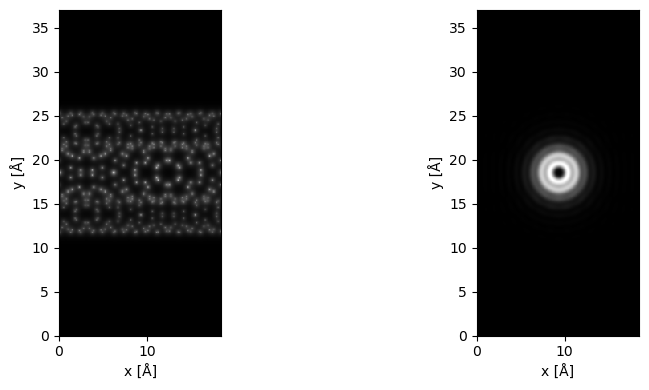

In [2]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=0, axis=(0,1))
padding = double_walled_cnt.cell[2,2] - double_walled_cnt.cell[0,0]/2
double_walled_cnt.center(vacuum=padding, axis=(0,1))

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)

double_walled_cnt_center = double_walled_cnt.cell.lengths()/2

frozen_phonons = abtem.temperature.FrozenPhonons(double_walled_cnt, 12, 0.075)

static_potential = abtem.Potential(
    #frozen_phonons,  # uncomment this for a realistic simulation     
    double_walled_cnt, # comment this for a realistic simulation
    gpts=(int(96*3*np.sqrt(2)/2),int(96*3*np.sqrt(2))),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

static_potential.project().show(ax=ax1)
probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=150,device="gpu")
probe.match_grid(static_potential)
probe.show(ax=ax2)

fig.tight_layout();

In [3]:
pixelated_detector = abtem.PixelatedDetector(max_angle=None)

grid_scan = abtem.GridScan(
    (0, static_potential.extent[1]/2-static_potential.extent[0]/2), (static_potential.extent[0],static_potential.extent[1]/2+static_potential.extent[0]/2),
    gpts=(36+1,36+1),
    endpoint=True
)

measurement = probe.scan(grid_scan, pixelated_detector, static_potential)
sx,sy,qx,qy = measurement.shape
crop_qx = (qx - 96)//2
crop_qy = (qy - 96*2)//2

array = measurement.array[:,:,crop_qx:crop_qx+96,crop_qy:crop_qy+96*2]
array = array.reshape((37,37,96,96,2)).sum(-1)

electrons_per_area = 1e6
electrons_per_probe = electrons_per_area*np.array(grid_scan.sampling).prod()
noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)

Potential:   0%|          | 0/75 [00:00<?, ?it/s]

Scan:   0%|          | 0/1369 [00:00<?, ?it/s]

In [4]:
dc = py4DSTEM.DataCube(noisy_array)
dc.calibration.set_R_pixel_size(measurement.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(measurement.calibrations[2].sampling)
dc.calibration.set_Q_pixel_units('mrad')
dc.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    2.248767617895552
             R_pixel_size:    0.515803041652313
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

## Single-slice Ptychography

Best fit rotation forced to 0 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|█| 1369/1369 [00:00<00:0


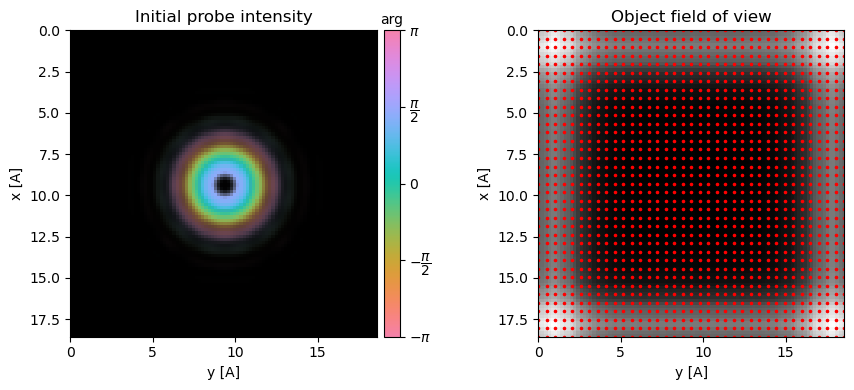

In [22]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dc,
    verbose=True,
    energy=80e3,
    semiangle_cutoff=25,
    defocus=150,
    storage='cpu',
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.01 and step _size: 0.5.
Reconstructing object and probe: 100%|█| 64/64 [00:02


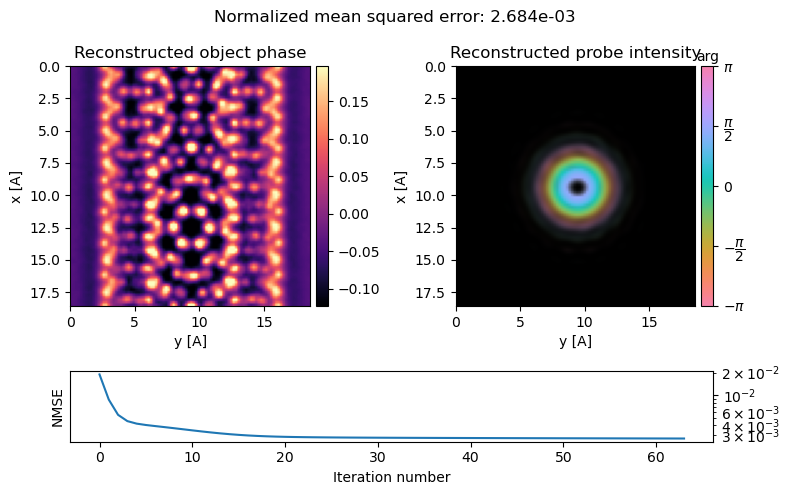

In [23]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    normalization_min=0.01,
).visualize(
)

## Visualization

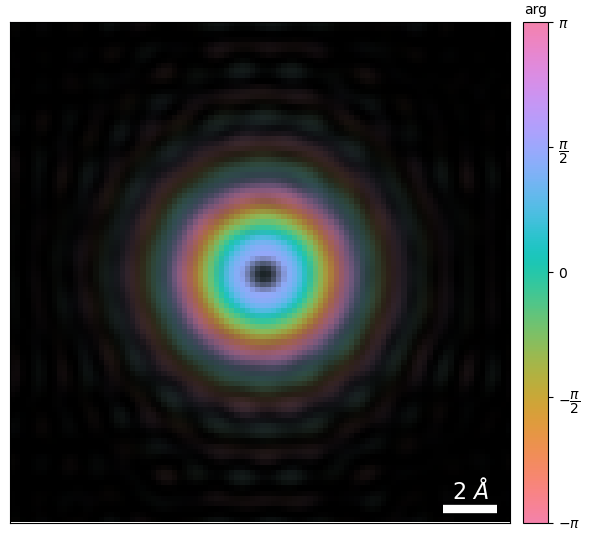

In [24]:
probe_fig, probe_ax = py4DSTEM.show_complex(
    ptycho.probe_centered,
    ticks=False,
    scalebar=True,
    pixelsize=ptycho.sampling[0],
    pixelunits=r"$\AA$",
    figsize=(6,6),
    returnfig=True,
)

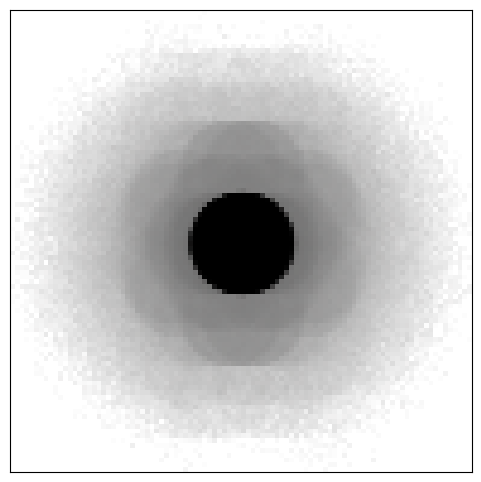

In [25]:
dc.get_dp_mean()
mean_dp_fig, ax = plt.subplots(figsize=(6,6))

py4DSTEM.show(
    dc.tree("dp_mean").data,
    vmin=0.275,
    vmax=0.975,
    power=0.005,
    cmap=cmr.neutral_r,
    ticks=False, 
    pixelsize=ptycho._reciprocal_sampling[0], 
    pixelunits='$\AA^{-1}$',
    figax =(mean_dp_fig,ax)
)

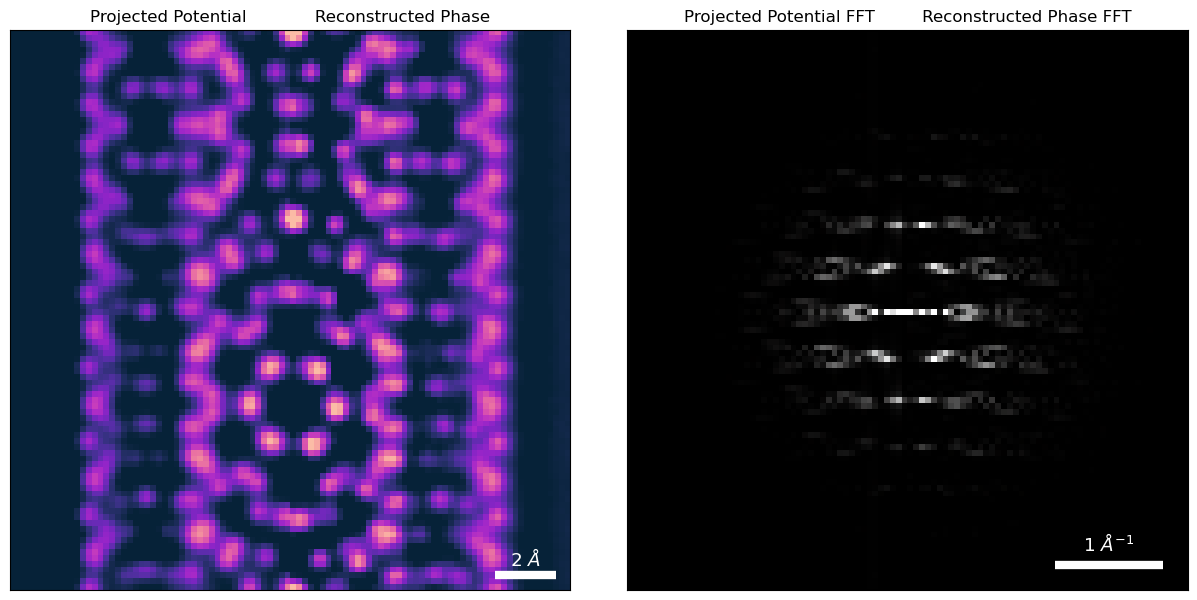

In [36]:
from scipy.ndimage import gaussian_filter,zoom

ptycho_sampling = ptycho.sampling[0]
upsampling_factor = 2
sigma = 1.0

gt_potential = abtem.Potential(
    double_walled_cnt,
    sampling=ptycho_sampling/upsampling_factor,
    slice_thickness=ptycho_sampling/upsampling_factor,
    projection="finite",
    parametrization="kirkland",
).build().project().array * abtem.utils.energy2sigma(80e3)

gt_potential = gaussian_filter(gt_potential,upsampling_factor*sigma)
gt_potential = zoom(gt_potential,1/upsampling_factor)[:,48:-48]

reconstructed_object = ptycho._crop_rotate_object_fov(np.angle(ptycho.object))
reconstructed_object -= reconstructed_object.min()

recon_comparison_fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,6))

py4DSTEM.show(
    np.hstack((
    gt_potential[:,:48],
    reconstructed_object[:,48:]
    )),
    vmin=0.333,
    vmax=0.999,
    cmap=cmap,
    ticks=False,
    scalebar=True, 
    pixelsize=ptycho.sampling[0], 
    pixelunits='$\AA$',
    title="Projected Potential\t\tReconstructed Phase".expandtabs(),
    figax=(recon_comparison_fig,ax1),
)

reconstructed_fft = np.fft.fftshift(np.abs(np.fft.fft2(reconstructed_object)))
gt_fft = np.fft.fftshift(np.abs(np.fft.fft2(gt_potential)))

py4DSTEM.show(
    np.hstack((
    gt_fft[:,:48],
    reconstructed_fft[:,48:]
    )),
    vmin=0.333,
    vmax=0.999,
    power=0.75,
    cmap=cmr.neutral,
    ticks=False,
    scalebar=True, 
    pixelsize=ptycho._reciprocal_sampling[0], 
    pixelunits='$\AA^{-1}$',
    title="Projected Potential FFT\t\tReconstructed Phase FFT".expandtabs(),
    figax=(recon_comparison_fig,ax2),
)

recon_comparison_fig.tight_layout()

## Postprocessing
> Done in Inkscape